<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to provide detailed discussions about using Gaussian Processes (GP) for classification problems.

<div class="alert alert-info">

**Note:** This material is based on Chapter 3 of the GPML book.

</div>

We now turn out attention to *classification* problems, where the target is not real, but categorical, i.e., $y \in \{C_1,C_2,\ldots,C_\mathcal{C}\}$, where $\mathcal{C}$ is the number of possible classes that the target can be in. We will work with probabilistic classification, where we are interested in:
$$
P(Y = C_1\vert X = {\bf x})
$$
> There are two general approaches to building probabilistic classifiers. One is to start with the joint probability distribution, $p({\bf x},y)$, which can be decomposed as $p({\bf x}\vert y)p(y)$ and then use *Bayes rule* to get $p(y\vert{\bf x})$. The other is to directly model $p(y\vert {\bf x})$ without making any assumptions about $p({\bf x})$. The former approach is called **generative models** and the latter approach is called **discriminative models**. 

<div class="alert alert-warning">
Gaussian process classification is discriminative.
</div>

We will see that, to a certain extent, applying GP to probabilistic classification is similar to applying GP to regression, as we saw earlier. However, the problem is much more demanding due to one key reason: *the likelihood function in a classification setting cannot be Gaussian*. This leads to a challenging issue that requires approximate solutions.

### Linear logistic regression model
Consider a binary classification setting, i.e., the targets can either be $+1$ or $-1$. In the logistic regression model, we directly model the conditional probability for the targets, as follows:
$$
p(y = +1 \vert {\bf x},{\bf w}) = \sigma({\bf w}^\top{\bf x})
$$
> $\sigma(\cdot)$ can be any *sigmoid* function, which is any monotonically increasing function from $\mathbb{R} \rightarrow [0,1]$. 

> A popular choice for $\sigma(\cdot)$ is the *logistic response function*, such that $\sigma(z) = \frac{1}{1 + \exp{-z}}$, in which case the classification model is called **linear logistic regression** (or just **logistic regression**).

> However, there are other possible choices as well. For instance, the **linear probit regression** model uses the probit function, which is the cumulative density of a standard normal distribution, i.e., $\sigma(z) = \int_{-\infty}^z\mathcal{N}(u\vert 0,1)du$

<div class="alert alert-info">
    
**Note:** For the subsequent discussions, we will use the logistic function as the response function.

</div>

Using this model, we can get the probability of $y$ to be any one of the labels:
$$
p(y = +1 \vert {\bf x},{\bf w}) = \sigma({\bf w}^\top{\bf x})\text{;   } p(y = -1 \vert {\bf x},{\bf w}) = 1 - p(y = +1 \vert {\bf x},{\bf w}) = \sigma(-{\bf w}^\top{\bf x})
$$

The above result uses the fact that the logistic function is symmetric, i.e., $1 - \sigma(z) = \sigma(-z)$.

Thus, if we are given a training data set, $\mathcal{D} = \{({\bf x}_i,y_i)\vert i = 1,\ldots,N\}$, the probability of the $i^{th}$ label is given by:
$$
p(y_i\vert {\bf x}_i,{\bf w}) = \sigma(y_i{\bf w}^\top{\bf x}_i)
$$

#### The non-Bayesian formulation of logistic regression
To learn the optimal weights, ${\bf w}$, one can calculate the log-likelihood of the training data set, i.e., 
$$
\mathcal{L}(\mathcal{D}\vert {\bf w}) = \sum_{i=1}^N \log{\sigma(y_i{\bf w}^\top{\bf x}_i})
$$
and then find the ${\bf w}$ that maximizes the log-likelihood. This can be done using a gradient based optimizer.

#### The Bayesian formulation of logistic regression
Assuming a Gaussian prior on ${\bf w}$, i.e., ${\bf w} \sim \mathcal{N}({\bf 0},\Sigma_p)$, the posterior distribution for ${\bf w}$ will be:
$$
p({\bf w}\vert \mathcal{D}) = \frac{p(\mathcal{D}\vert{\bf w})p({\bf w})}{\int p(\mathcal{D}\vert{\bf w}')p({\bf w}')d{\bf w}'}
$$

Now, this is the start of all our troubles :(


For linear regression, the posterior for ${\bf w}$ was also a Gaussian. However, we do not get a similar simple analytical form here.

If we ignore the denominator, we can calculate the *unnormalized* log posterior for ${\bf w}$ as:
$$
\log{p({\bf w}\vert \mathcal{D})} \stackrel{c}{=} -\frac{1}{2}{\bf w}^\top \Sigma_p{\bf w} + \sum_{i=1}^N \log{\sigma(y_i{\bf w}^\top{\bf x}_i)}
$$
We can maximize the above unnormalized log posterior and get the MAP estimate for ${\bf w}$ (The objective function is indeed a nice concave function, and one can use a gradient based optimizer, e.g., *Newtons's method* to get the MAP estimate.).

#### Example:
Consider a 2-D data set and a binary classification problem. We are interested in learning a weight vector, ${\bf w}$ that can be used to assign the probability of a test instance to belong to class $+1$ or $-1$. For the sake of visualization, we will ignore the intercept term and assume that ${\bf w}$ is two-dimensional.

We first define a Gaussian prior on ${\bf w}$.


In [4]:
%run Utilities.ipynb

In [7]:
prior_mean = np.zeros((2,))
prior_cov = np.eye(2)

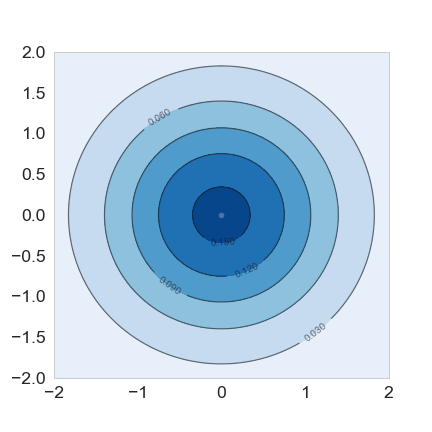

In [10]:
# plot the prior distribution
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

plot_contours(ax,prior_mean,prior_cov,limits=(-2,2),levels=5,cm='Blues')
ax.scatter(prior_mean[0],prior_mean[1])

Next we consider a small training set:

In [11]:
X = np.array([
    [-5,1],
    [1,0],
    [-1,-5],
    [-0.5,-0.5],
    [1,5],
    [5,4]
])
y = np.array([-1,-1,-1,+1,+1,+1])

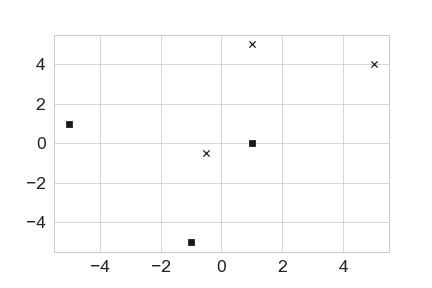

In [17]:
plt.scatter(X[0:3,0],X[0:3,1],c='k',marker='s',s=40)
plt.scatter(X[3:,0],X[3:,1],c='k',marker='x',s=40)

Next we plot the posterior pdf for ${\bf w}\vert X,{\bf y}$. But we do not have an analytical form for that. However, we can compute the unnormalized log pdf (as shown above) and visualize that.

In [38]:
def logpdf(w,X,y,Sigma_p):
    f = np.dot(X,w)
    return -0.5*np.dot(w.T,np.linalg.solve(Sigma_p,w)) + np.sum(1/(1 + np.exp(-y[:,np.newaxis]*f)))

In [51]:
# compute the objective function for a range of values for w and w0
w1s = np.linspace(-2, 2, 40)
w2s = np.linspace(-2, 2, 40)
W1, W2 = np.meshgrid(w1s, w2s)
logpdfs = []
for w1,w2 in zip(W1.flatten(),W2.flatten()):
    logpdfs.append(logpdf(np.array([[w1],[w2]]),X,y,prior_cov))

logpdfs = np.array(logpdfs)
L = np.reshape(logpdfs,(len(w1s),len(w2s)))    

<a list of 22 text.Text objects>

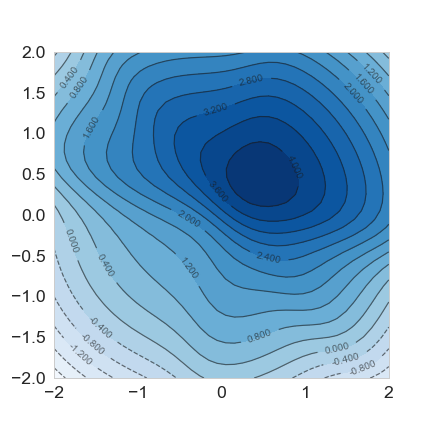

In [52]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = ax.contourf(W1, W2, L, levels=20,cmap='Blues')
cset = ax.contour(W1, W2, L, levels=20, colors='k',alpha=0.6)
ax.clabel(cset, inline=1, fontsize=10)

Note how the unnormalized pdf above is not Gaussian. How can we get the posterior predictive distribution for a new test instance, ${\bf x}_*$?
$$
p(y_* = 1\vert {\bf x}_*,X,{\bf y}) = \int p(y_* = 1\vert {\bf w},{\bf x}_*)p({\bf w}\vert X,{\bf y})d{\bf w}
$$
Since the posterior pdf of ${\bf w}$ is not a *well-behaved* function, the above integral is tough to calculate. In fact, we cannot even sample ${\bf w}$s from the posterior to do Monte-carlo sampling.

A pain-staking way to *build* the predictive distribution would be to do a numeric integration over the entire grid.

In [57]:
def predictiveProb(x_star,X,y,Sigma_p):
    w1s = np.linspace(-2, 2, 40)
    w2s = np.linspace(-2, 2, 40)
    W1, W2 = np.meshgrid(w1s, w2s)
    pred_prob = 0
    for w1,w2 in zip(W1.flatten(),W2.flatten()):
        w = np.array([[w1],[w2]])
        pdf = np.exp(logpdf(w,X,y,prior_cov))
        pred_w = 1/(1 + np.exp(-1*np.dot(w.T,x_star)))
        pred_prob += pdf*pred_w
    return pred_prob


In [67]:
x1s = np.linspace(-6, 6, 40)
x2s = np.linspace(-6, 6, 40)
X1, X2 = np.meshgrid(x1s, x2s)
pred_probs = []
for x1,x2 in zip(X1.flatten(),X2.flatten()):
    pred_probs.append(predictiveProb(np.array([[x1],[x2]]),X,y,prior_cov))

pred_probs = np.array(pred_probs)
P = np.reshape(pred_probs,(len(x1s),len(x2s)))    

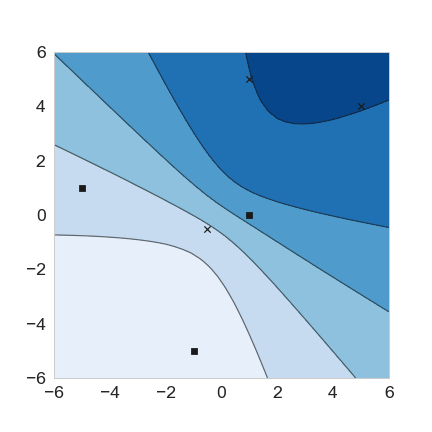

In [68]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = ax.contourf(X1, X2, P, levels=5,cmap='Blues')
cset = ax.contour(X1, X2, P, levels=5, colors='k',alpha=0.6)
ax.scatter(X[0:3,0],X[0:3,1],c='k',marker='s',s=40)
ax.scatter(X[3:,0],X[3:,1],c='k',marker='x',s=40)
#ax.clabel(cset, inline=1, fontsize=10)

### Gaussian Process Classification
The basic idea of using GP for classification is similar to the regression setting - we place a GP prior over the the *latent function*, $f({\bf x})$, and then "squash" this through the logistic function to obtain a prior on:
$$
\pi({\bf x}) \triangleq p(y = +1\vert {\bf x}) = \sigma(f({\bf x}))
$$
> We have introduced a new notation, we are using the function $\pi({\bf x})$ to denote the probability of the class to be +1, for a given ${\bf x}$ - this is just a short-cut notation. $\pi()$ is a deterministic function of $f()$, and since $f()$ is a stochastic function (sampled from the GP prior), so will be $\pi()$

> You can draw parallels between GPR and GPC. In GPR, we assumed that the observation, $y$, was connected to $f({\bf x})$ through $y = f({\bf x}) + \epsilon, \epsilon \sim \mathcal{N}(0,\sigma_n^2)$. Here, $\pi({\bf x})$ is conected to $f({\bf x})$ through $\pi({\bf x}) = f({\bf x})$. Notice that for GPC we assume a *noise-free* relationship.

#### Obtaining predictive distribution for a test instance
The inference in GPC is divided into 2 steps:

First, find the distribution of the latent function, for the given test case:
$$
p(f_* \vert X,{\bf y},{\bf x}_*) = \int p(f_*\vert X,{\bf x}_*,{\bf f})p({\bf f}\vert X,{\bf y})d{\bf f}
$$
The first term is given to us through the GP prior (*recall*: the conditional on a new test instance, will be a Gaussian). The second term is the probability of obtaining a given latent function, given the training data:
$$
p({\bf f}\vert X,{\bf y}) = \frac{p({\bf y}\vert {\bf f})p({\bf f}\vert X)}{p({\bf y}\vert X)}
$$

Second, use the distribution over the latent $f_*$ to produce a probabilistic prediction:
$$
\bar{\pi}_* \triangleq p(y_* = +1 \vert X,{\bf y},{\bf x}_*) = \int \sigma(f_*)p(f_*\vert X,{\bf y},{\bf x}_*)df_*
$$

#### Computational tractability issues
The integral in (10) is analytically intractable, due to the non-Gaussian probability distribution, $p({\bf y}\vert {\bf f},X)$. The integral in (11) is generally interactable, though one can do a simple numerical integration (at least for the binary classification case). 

### Approximate inference methods
1. `Monte carlo sampling`
2. `Laplace approximation`
3. `Expectation Propagation`

Here we will discuss the latter two methods.

### Laplace Approximation for Binary GP Classification
The general idea is to approximate the posterior $p({\bf f}\vert X,{\bf y})$ with a Gaussian approximation, $q({\bf f}\vert X, {\bf y})$.  Once we have $q()$, we can plug that into (10) above, and get a Gaussian posterior for $p(f_* \vert X,{\bf y},{\bf x}_*)$. 

The strategy behind Laplace's method is:
- Consider the log-posterior expression, i.e., $\log{p({\bf f}\vert X,{\bf y})}$
> Question: Is this known?
- Find the value of ${\bf f}$ at which the above log-posterior is maximum - $\hat{\bf f}$
- Do a second order Taylor series expansion of $\log{p({\bf f}\vert X,{\bf y})}$ around $\hat{\bf f}$
- Obtain the Gaussian approximation:
$$
q({\bf f}\vert X, {\bf y}) = \mathcal{N}(\hat{\bf f},A^{-1})
$$

> If you look at the log-posterior of a Gaussian distribution (say, ${\bf z} \sim \mathcal{N}({\bf \mu},\Sigma)$), it has the following form: 
$$
\log{p({\bf z})} = -\frac{1}{2}({\bf z}-{\bf \mu})^\top\Sigma^{-1}({\bf z}-{\bf \mu})-\frac{1}{2}\log{\vert \Sigma\vert}-\frac{N}{2}\log{2\pi} 
$$
So if we can approxiate the log pdf of any distribution to the above form, then we can approximate the distribution with a Gaussian distribution.


We will now see how to get $\hat{\bf f}$ and $A$

#### Posterior
Recall that the posterior distribution, $p({\bf f}\vert X,{\bf y})$ is given by:
$$
p({\bf f}\vert X,{\bf y}) = \frac{p({\bf y}\vert {\bf f})p({\bf f}\vert X)}{p({\bf y}\vert X)}
$$
but the denominator is independent of ${\bf f}$ so we can ignore it, when maximizing w.r.t. ${\bf f}$.

Or the log-posterior can be written as:
\begin{eqnarray}
\Psi({\bf f}) & \triangleq & \log{p({\bf y}\vert {\bf f})} + \log{p({\bf f}\vert X)}\\
              & =          & \log{p({\bf y}\vert {\bf f})} - \frac{1}{2}{\bf f}^\top K^{-1}{\bf f} - \frac{1}{2}\log{\vert K\vert} - \frac{N}{2}\log{2\pi}
\end{eqnarray}

Remember that $p({\bf y}\vert{\bf f}) = \prod_i\sigma(y_if_i)$, assuming that the data is i.i.d. However, we will not subsitute it yet in the above equation.

Let $\hat{{\bf f}}$ be the value of ${\bf f}$ at which $\Psi({\bf f})$ is maximum, i.e., $\nabla \Psi(\hat{{\bf f}}) = {\bf 0}$.

The *Taylor's series expansion* of $\Psi({\bf f})$ around $\hat{{\bf f}}$ will be:
$$
\Psi({\bf f}) \approx \Psi(\hat{{\bf f}}) + \nabla\Psi(\hat{{\bf f}})({\bf f}-\hat{{\bf f}}) + \frac{1}{2}({\bf f}-\hat{{\bf f}})^\top \nabla^2\Psi(\hat{\bf f})({\bf f}-\hat{{\bf f}})
$$
Here we are ignoring higher-order terms beyond 2. The second term will disappear because $\nabla \Psi(\hat{{\bf f}}) = {\bf 0}$. Which means that the log posterior can be approximated as:
$$
\Psi({\bf f}) \approx \Psi(\hat{{\bf f}}) + \frac{1}{2}({\bf f}-\hat{{\bf f}})^\top \nabla^2\Psi(\hat{\bf f})({\bf f}-\hat{{\bf f}})
$$
Thus, one can approximate the original $p({\bf f}\vert X,{\bf y})$ with a Gaussian distribution whose mean is $\hat{{\bf f}}$ and covariance matrix is $\nabla^2\Psi(\hat{\bf f})$. 



#### Obtaining $\hat{\bf f}$
This can be done by maximizing the objective function in (17) with respect to ${\bf f}$. This can be done using the *Newtons' method*. 

#### Obtaining $\nabla^2\Psi(\hat{\bf f})$
The second order gradient (more commonly known as the **Hessian**) can be obtained using matrix calculus (ignoring the steps here, this will be explained during the class).

The final result for $\nabla^2\Psi(\hat{\bf f})$ is:
$$
\nabla^2\Psi(\hat{\bf f}) = - W - K^{-1}
$$
where $W$ is a $N \times N$ diagonal matrix, whose $i^{th}$ diagonal term is given by:
\begin{eqnarray}
W_{ii} & = & \frac{\partial^2}{\partial f_i^2} \log{p(y_i\vert f_i)}\\
       & = & \frac{\partial^2}{\partial f_i^2} -\log(1 + \exp{(-y_if_i)})\\
       & \vdots& \\
       & = & -\pi_i(1 - \pi_i)
\end{eqnarray}
where $\pi_i = p(y_i = 1\vert f_i)$